#Bike Forecasting demand Time series 

In this notebook, we will see what data we have 

We are going to do a naive foracast and compare to Machine Learning Forecast


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error


from  datetime import datetime, timedelta, date

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Station bike dataset 


In [ ]:
#Read one bike station 
INPUT_PARIS='/content/drive/My Drive/Colab Notebooks/Bike_sharing/challenge/part_1/paris/stations/'
df=pd.read_csv(INPUT_PARIS+'09037-clichy-parme.csv' ,parse_dates=True)

In [ ]:
df.head(6)

,moment,bikes,spaces
0,2016-04-01 00:05:55,7,16
1,2016-04-01 00:06:41,7,16
2,2016-04-01 00:07:27,7,16
3,2016-04-01 00:17:30,7,16
4,2016-04-01 00:27:33,7,16
5,2016-04-01 00:37:37,7,16


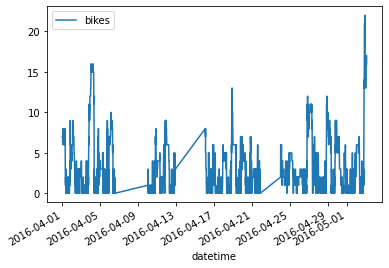

In [ ]:
df_mini=df.loc[:5000]  #Take a small part of out Df to see some seaonality 
df_mini.plot(x='datetime', y='bikes')

[Text(0, 0.5, 'bikes'),
 Text(0.5, 0, 'weekday'),
 Text(0.5, 1.0, 'Box Plot On bikes Across Weekday')]

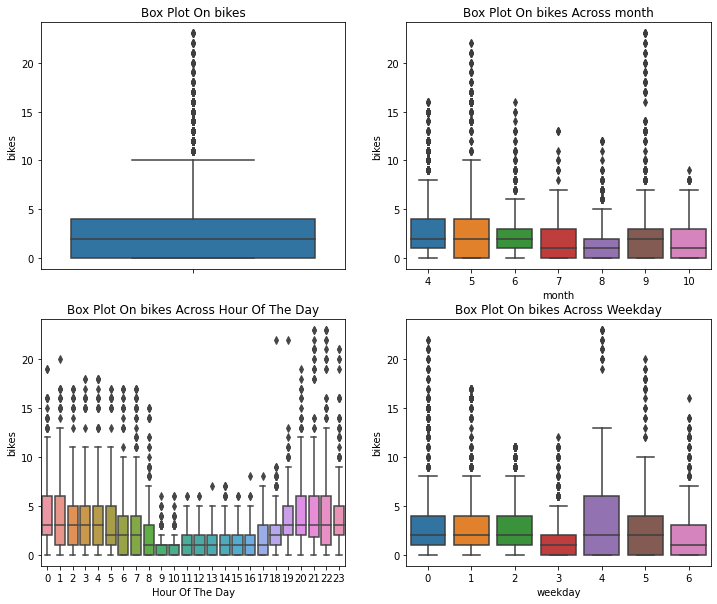

In [ ]:
#Analyse the DF of one station to see demand whithin on hour or month and compare them 

fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=df,y="bikes",orient="v",ax=axes[0][0])
sns.boxplot(data=df,y="bikes",x="month",orient="v",ax=axes[0][1])
sns.boxplot(data=df,y="bikes",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=df,y="bikes",x="weekday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='bikes',title="Box Plot On bikes")
axes[0][1].set(xlabel='month', ylabel='bikes',title="Box Plot On bikes Across month")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='bikes',title="Box Plot On bikes Across Hour Of The Day")
axes[1][1].set(xlabel='weekday', ylabel='bikes',title="Box Plot On bikes Across Weekday")

 la médiane du nombre de vélo est de 3 mais le maximum  est jusqu'a 25
 Il n'y a pas bcp de vélo emprunter pdt les vacances scolaires, mais pas mal de vélo pendant les autres mois
 La répartition de la demande de vélo en fonction des heures est forte et constante de 19h-22h,
                                                                 forte et constante de 2-8h
                                                                 faible de 9h-16h
        
        


[Text(0, 0.5, 'Bikes Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Bikes Count By Hour Of The Day Across Weekdays'),
 None]

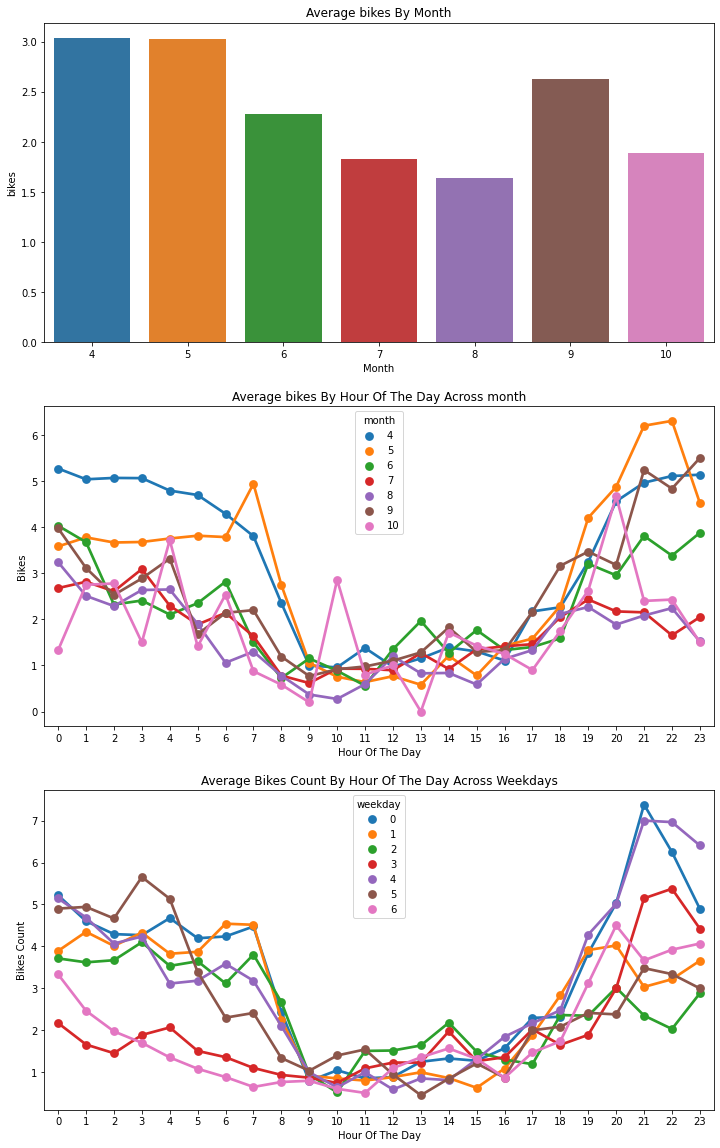

In [ ]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,20)


monthAggregated = pd.DataFrame(df.groupby("month")["bikes"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="bikes",ascending=False)
sns.barplot(data=monthSorted,x="month",y="bikes",ax=ax1)
ax1.set(xlabel='Month', ylabel='bikes',title="Average bikes By Month")

hourAggregated = pd.DataFrame(df.groupby(["hour","month"],sort=True)["bikes"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["bikes"],hue=hourAggregated["month"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Bikes',title="Average bikes By Hour Of The Day Across month",label='big')



hourAggregated = pd.DataFrame(df.groupby(["hour","weekday"],sort=True)["bikes"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["bikes"],hue=hourAggregated["weekday"], data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Bikes Count',title="Average Bikes Count By Hour Of The Day Across Weekdays",label='big')



# Weather DataSet 


In [4]:
df_weather = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Bike_sharing/challenge/part_1/paris/weather.csv', index_col=0)
df_weather.head(6)

,clouds,description,humidity,pressure,temperature,wind
moment,,,,,,
2016-04-01 00:00:00,75,broken clouds,81,1015.0,6.50,4.6
2016-04-01 00:30:00,75,light intensity drizzle,81,1016.0,6.50,4.1
2016-04-01 01:30:00,75,broken clouds,81,1017.0,6.16,4.6
2016-04-01 02:00:00,75,mist,87,1017.0,5.50,4.6
2016-04-01 02:30:00,75,mist,87,1017.0,5.33,4.6
2016-04-01 03:00:00,0,mist,87,1017.0,5.00,3.6


# Coordinates DataSet

In [7]:
df_coord = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Bike_sharing/challenge/part_1/paris/coordinates.csv')
df_coord.head(6)

,altitude,latitude,longitude,station
0,35.904366,48.872430,2.355489,10007-chateau-deau
1,33.244411,48.866285,2.325249,01020-rivoli-concorde
2,107.128578,48.875518,2.392961,19121-belleville-pre-saint-gervais
3,33.558167,48.827471,2.278550,21311-gambetta-issy-les-moulineaux
4,41.710220,48.870690,2.303222,08041-champs-elysees-lincoln
5,35.155052,48.858943,2.331418,07006-quai-voltaire


# Features Engineering 

In [15]:
#Create a file that contains all the number of baikes available with the station name.

INPUT_PARIS='/content/drive/My Drive/Colab Notebooks/Bike_sharing/challenge/part_1/paris/stations/'
import os
dfs=[]
for f in os.listdir(INPUT_PARIS):# Loop in the directory that contains all the paris bike station
  t=f.split('.')#Split the string of the station, and keep only the Id
  
  #Read one csv
  df=pd.read_csv(INPUT_PARIS+f ,parse_dates=True)#Read the Df 
  df['datetime']=pd.to_datetime(df['moment'])# Date into Datetime variabla

  #DATA CLEANING 
  df=df.set_index('datetime')
  df = df.resample('30min').mean()#Resample our DF every 30 minutes 
  df = df.reset_index()
  df['station'] = t[0]

  dfs.append(df)# In each iteration put the DF in a Liste

df = pd.concat(dfs, axis=0)
df = df.drop(['spaces'], axis = 1) #We forcast the bikes avaiblable, the spaces variable is corrolated to our target.



df.to_csv('/content/drive/My Drive/Colab Notebooks/Bike_sharing/challenge/part_1/paris/master.csv', index = False)# Save DF


In [5]:
# Return a DF for one station with only the target and datetime (station is num 0937-clichy-parme)
def create_df():
  INPUT_PARIS='/content/drive/My Drive/Colab Notebooks/Bike_sharing/challenge/part_1/paris/stations/'
  df=pd.read_csv(INPUT_PARIS+'09037-clichy-parme.csv' ,parse_dates=True)
  df['datetime']=pd.to_datetime(df['moment'])
  df=df.drop(['moment'], axis=1)
  return df

#df=create_df()


In [6]:

def merge_coord(df):#Fonction that return th DF merged whith the coord's DataFrame

  coord= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Bike_sharing/challenge/part_1/paris/coordinates.csv')
  coord=coord.drop(['latitude','longitude'], axis=1)

  df_merge = pd.merge(df, coord, on='station')

  return df_merge

In [7]:
def merge_weather(df):#Fonction that return th DF merged whith the weather's DataFrame
  df['datetime']=pd.to_datetime(df['datetime'])
  df=df.set_index(['datetime'])
  df=df.sort_index().reset_index()

  df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Bike_sharing/challenge/part_1/paris/weather.csv', index_col=0)
  df2.index=pd.to_datetime(df2.index)
  df2=df2.sort_index().reset_index()
  df2['datetime'] = df2['moment'] 
  df2['key']=df2.index

  df3=pd.merge_asof(df,df2,on='datetime',direction='nearest')
  df3['diff']=(df3.datetime-df3.moment).abs()
  dropcol=['diff','key','moment']
  df3 = df3.drop(dropcol, axis=1)
  #df =df3.copy()


  return df3



In [8]:
def weather_features(df):#Create features about the wheather 
  df['beau_temps'] = (df['description'].str.contains('clear sky') 
                      | df['description'].str.contains('few clouds') 
                      | df['description'].str.contains('broken clouds')
                      | df['description'].str.contains('scattered clouds')
                      | df['description'].str.contains('Sky is clear')).astype(int)

  df['nuageux'] = (df['description'].str.contains('mist') 
                  | df['description'].str.contains('fog')
                  | df['description'].str.contains('overcast clouds')).astype(int)


  df['pluvieux'] = (df['description'].str.contains('light rain') 
                  | df['description'].str.contains('light intensity drizzle')
                  | df['description'].str.contains('drizzle')
                  | df['description'].str.contains('moderate rain')
                  | df['description'].str.contains('light intensity shower rain')).astype(int)

  df['pluie'] = (df['description'].str.contains('heavy intensity rain') 
                  | df['description'].str.contains('light intensity drizzle')
                  | df['description'].str.contains('moderate rain')
                  | df['description'].str.contains('rain')
                  | df['description'].str.contains('shower rain')
                  | df['description'].str.contains('light snow')).astype(int)

  df['orage'] = (df['description'].str.contains('thunderstorm') 
                  | df['description'].str.contains(' and snow')
                  | df['description'].str.contains('moderate rain')
                  | df['description'].str.contains('very heavy')).astype(int)

  df=df.drop('description', axis=1)

  return df
#df=weather_features(df)

In [11]:
def clean_data(df):
  df=df.set_index('datetime')
  df = df.resample('30min').mean()#Resample out Data every 30 minutes 
  df = df.reset_index()
  return df

In [27]:
def create_date_features(df):#Create features about the Datetime and lags features
  df['hour']=df['datetime'].dt.hour
  df['day']=df['datetime'].dt.day
  df['month']=df['datetime'].dt.month
  df['weekday']=df['datetime'].dt.weekday

  df['lag_30m']= df['bikes'].shift(-1) #(30 minutes in the past)
  df['lag_7j']=df['bikes'].shift(-24*2*7)#(The same DateTime but 1 week in the past )
  return df

In [10]:
def weather_lag(df):# Lags features about the weaher (+30 minutes)


  df['lag_beau_temps']= df['beau_temps'].shift(1)# Lag beau_temps 30 minutes in the future
  df['lag_nuageux']=df['nuageux'].shift(1)# Lag beau_nuageux 30 minutes in the future
  df['lag_pluvieux']=df['pluvieux'].shift(1)
  df['lag_pluie']=df['pluie'].shift(1)
  df['lag_orage']=df['orage'].shift(1)
  return df

In [12]:
def fillna(df):
  df=df.fillna(method='ffill')
  df=df.fillna(method='bfill')
  return df

In [13]:
def one_encod(df):
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  df['station'] = le.fit_transform(df['station'])
  return df

In [28]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Bike_sharing/challenge/part_1/paris/master.csv',parse_dates=True)
df = merge_weather(df)
df = merge_coord(df)
df = weather_features(df)
df = weather_lag(df)
#df = clean_data(df) #We already clean data when we merged all the station's bike 
df = create_date_features(df)
df = one_encod(df)
df = fillna(df)



In [38]:
df[1200:1210] #Check is all is correct and the Lags is correct also 

,datetime,bikes,station,clouds,humidity,pressure,temperature,wind,altitude,beau_temps,nuageux,pluvieux,pluie,orage,lag_beau_temps,lag_nuageux,lag_pluvieux,lag_pluie,lag_orage,hour,day,month,weekday,lag_30m,lag_7j
1200,2016-04-26 00:00:00,12.0,1014,75,87,1008.0,7.24,4.1,35.218903,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0,26,4,1,13.0,15.000000
1201,2016-04-26 00:30:00,13.0,1014,75,87,1008.0,7.05,4.6,35.218903,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0,26,4,1,14.0,16.000000
1202,2016-04-26 01:00:00,14.0,1014,75,87,1008.0,7.00,4.6,35.218903,1,0,0,0,0,0.0,0.0,1.0,1.0,0.0,1,26,4,1,14.0,16.250000
1203,2016-04-26 01:30:00,14.0,1014,75,87,1007.0,7.09,4.6,35.218903,0,0,1,1,0,0.0,0.0,1.0,1.0,0.0,1,26,4,1,14.0,17.000000
1204,2016-04-26 02:00:00,14.0,1014,75,87,1007.0,7.12,6.2,35.218903,0,0,1,1,0,0.0,0.0,1.0,1.0,0.0,2,26,4,1,14.0,17.000000
1205,2016-04-26 02:30:00,14.0,1014,75,87,1007.0,7.05,5.1,35.218903,0,0,1,1,0,0.0,0.0,1.0,1.0,0.0,2,26,4,1,14.0,17.166667
1206,2016-04-26 03:00:00,14.0,1014,75,87,1007.0,7.21,5.1,35.218903,0,0,1,1,0,0.0,0.0,1.0,1.0,1.0,3,26,4,1,14.0,17.000000
1207,2016-04-26 03:30:00,14.0,1014,75,81,1006.0,7.21,5.1,35.218903,0,0,1,1,1,0.0,0.0,1.0,1.0,1.0,3,26,4,1,14.0,17.000000
1208,2016-04-26 04:00:00,14.0,1014,75,87,1006.0,6.76,3.6,35.218903,0,0,1,1,1,0.0,0.0,1.0,1.0,1.0,4,26,4,1,14.0,17.000000
1209,2016-04-26 04:30:00,14.0,1014,75,87,1006.0,6.19,5.1,35.218903,0,0,1,1,1,0.0,0.0,1.0,1.0,0.0,4,26,4,1,14.0,17.000000


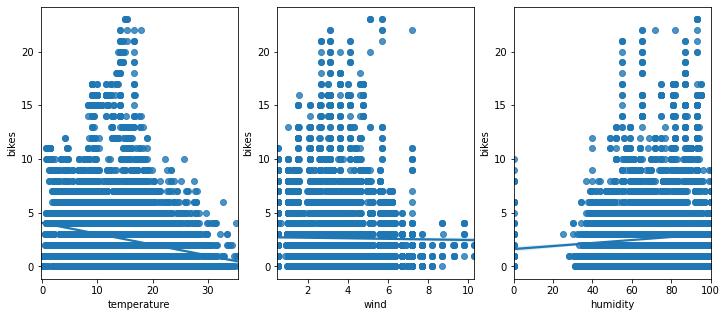

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temperature", y="bikes", data=df,ax=ax1)
sns.regplot(x="wind", y="bikes", data=df,ax=ax2)
sns.regplot(x="humidity", y="bikes", data=df,ax=ax3)

La température influence la demande de vélo, s'il fait trop chaud la demande baisse fortement 
                                             les températures fraiches influencent légérement jusqu'a attaindre une moyenne minimum
                                             

bcp de vent (>8) pas bcp de vélo 


et t'as compris pour l'humidité



Text(0.5, 1.0, 'Matrice de corrélation \n')

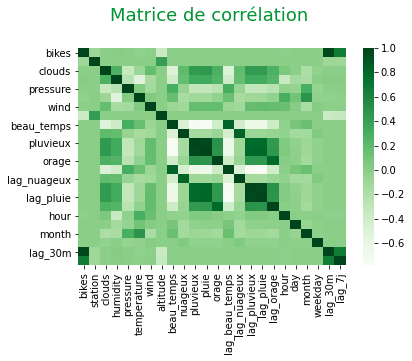

In [22]:
sns.heatmap(df.corr(), annot=False, cmap='Greens')
plt.title("Matrice de corrélation \n", fontsize=18, color='#009432')






La matrice de corrélation, bikes et spaces sont très colérée, ce qui est évident.

La température et l'humidité sont un peu colérées
les nuages et la préssion atmosphérique sont un peu colérées 

sinon le reste est tres corrècte 

# Naive foracast on one station


In [ ]:
dfs=[]
for i in range(0,7):
  df_mean = df[df['weekday'] == i ]
  df_mean = df_mean.groupby(['day', 'hour']).mean().reset_index().groupby(['hour']).mean().reset_index()
  #df_mean = df_mean.groupby(['hour']).mean().reset_index()
  dfs.append(df_mean)

final=pd.concat(dfs)
final

,hour,day,bikes,spaces,month,weekday
0,0,14.956522,3.332428,19.645833,6.826087,0.0
1,1,14.956522,3.366848,19.611413,6.826087,0.0
2,2,14.956522,3.469928,19.508333,6.826087,0.0
3,3,14.956522,3.503623,19.474638,6.826087,0.0
4,4,14.956522,3.552536,19.425725,6.826087,0.0
...,...,...,...,...,...,...
19,19,15.304348,2.666977,20.267805,6.782609,6.0
20,20,15.304348,3.074638,19.903623,6.782609,6.0
21,21,15.304348,3.607065,19.368478,6.782609,6.0
22,22,15.304348,3.432997,19.545264,6.782609,6.0


In [ ]:
dfh=[]
for i in range(0,8):
  df_score = df[df['month'] == 7]
  df_score  = df_score[df_score['day'] == i ]
  
  dfh.append(df_score)

df_score=pd.concat(dfh)
df_score = df_score[::2]
df_score= df_score.set_index("datetime")

In [ ]:
import sklearn.metrics as metrics
score = np.sqrt(metrics.mean_absolute_error(final['bikes'], df_score['bikes']))
score

1.318472177392885

In [ ]:
final.index = df_score.index
final

,hour,day,bikes,spaces,month,weekday,Actual
datetime,,,,,,,
2016-07-01 00:00:00,0,14.956522,3.332428,19.645833,6.826087,0.0,7.0
2016-07-01 01:00:00,1,14.956522,3.366848,19.611413,6.826087,0.0,13.0
2016-07-01 02:00:00,2,14.956522,3.469928,19.508333,6.826087,0.0,11.0
2016-07-01 03:00:00,3,14.956522,3.503623,19.474638,6.826087,0.0,9.0
2016-07-01 04:00:00,4,14.956522,3.552536,19.425725,6.826087,0.0,9.0
...,...,...,...,...,...,...,...
2016-07-07 19:00:00,19,15.304348,2.666977,20.267805,6.782609,6.0,3.0
2016-07-07 20:00:00,20,15.304348,3.074638,19.903623,6.782609,6.0,3.0
2016-07-07 21:00:00,21,15.304348,3.607065,19.368478,6.782609,6.0,3.0


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(( y_true.mean() - y_pred.mean() ) / y_true.mean() )) * 100
mean_absolute_percentage_error(np.array(df_score['bikes']) , np.array( final['bikes'])) 



11.277261864304707

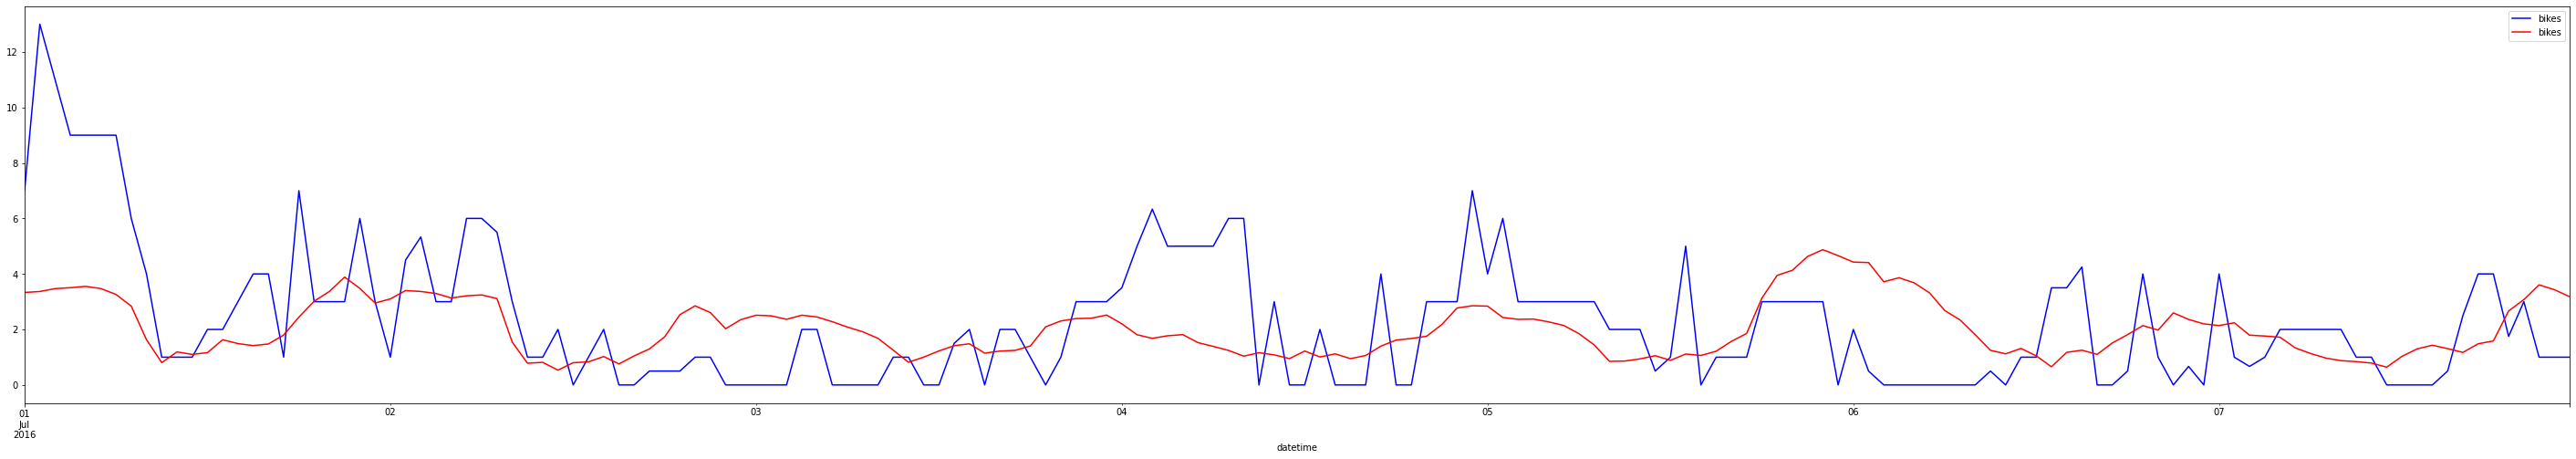

In [ ]:
ax = df_score['bikes'].plot(figsize=(50,8), legend=True, color='blue')
final['bikes'].plot(legend=True, color='red', figsize=(50,8))

In [ ]:
pred =df['bikes']
pred

Series([], Name: bikes, dtype: float64)

In [ ]:

df.to_csv('/content/drive/My Drive/Colab Notebooks/Bike_sharing/challenge/part_1/paris/master_final.csv', index = False)


In [ ]:
df = create_df()
df = merge_weather(df)
#df = merge_coord(df)
df = weather_features(df)
df = weather_lag(df)
df = clean_data(df)
df = create_date_features(df)
#df = one_encod(df)
df = fillna(df)
df= df.drop(['spaces'], axis=1)
df = df.set_index('datetime')
df.head()


,bikes,clouds,humidity,pressure,temperature,wind,beau_temps,nuageux,pluvieux,pluie,orage,lag_beau_temps,lag_nuageux,lag_pluvieux,lag_pluie,lag_orage,hour,day,month,weekday,lag_30m,lag_7j
datetime,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 00:00:00,7.000000,75.0,81.0,1015.4,6.500000,4.4,0.600000,0.000000,0.4,0.4,0.0,0.400000,0.0,0.600000,0.600000,0.0,0,1,4,4,7.00,7.0
2016-04-01 00:30:00,7.000000,75.0,81.0,1016.0,6.500000,4.1,0.000000,0.000000,1.0,1.0,0.0,0.333333,0.0,0.666667,0.666667,0.0,0,1,4,4,7.00,7.0
2016-04-01 01:00:00,6.750000,75.0,81.0,1017.0,6.160000,4.6,1.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0,1,1,4,4,7.00,7.0
2016-04-01 01:30:00,7.000000,75.0,85.0,1017.0,5.720000,4.6,0.333333,0.666667,0.0,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.0,1,1,4,4,6.75,7.0
2016-04-01 02:00:00,7.666667,75.0,87.0,1017.0,5.386667,4.6,0.000000,1.000000,0.0,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.0,2,1,4,4,7.00,7.0


In [ ]:


df['bikes']=df['bikes'].astype('float16')


df['pressure']=df['pressure'].astype('float16')
df['temperature']=df['temperature'].astype('float16')
df['wind']=df['wind'].astype('float16')
df['altitude']=df['altitude'].astype('float16')

df['lag_beau_temps']=df['lag_beau_temps'].astype('float16')
df['lag_nuageux']=df['lag_nuageux'].astype('float16')
df['lag_pluvieux']=df['lag_pluvieux'].astype('float16')
df['lag_orage']=df['lag_orage'].astype('float16')
df['lag_30m']=df['lag_30m'].astype('float16')
df['lag_7j']=df['lag_7j'].astype('float16')


df['station']=df['station'].astype('int8')
df['clouds']=df['clouds'].astype('int8')
df['humidity']=df['humidity'].astype('int8')
df['pressure']=df['pressure'].astype('int16')


df['beau_temps']=df['beau_temps'].astype('int8')
df['nuageux']=df['nuageux'].astype('int8')
df['pluvieux']=df['pluvieux'].astype('int8')
df['pluie']=df['pluie'].astype('int8')
df['orage']=df['orage'].astype('int8')


df['hour']=df['hour'].astype('int8')
df['day']=df['day'].astype('int8')
df['month']=df['month'].astype('int8')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10340547 entries, 0 to 10340546
Data columns (total 25 columns):
 #   Column          Dtype         
---  ------          -----         
 0   datetime        datetime64[ns]
 1   bikes           float16       
 2   station         int8          
 3   clouds          int8          
 4   humidity        int8          
 5   pressure        int16         
 6   temperature     float16       
 7   wind            float16       
 8   altitude        float16       
 9   beau_temps      int8          
 10  nuageux         int8          
 11  pluvieux        int8          
 12  pluie           int8          
 13  orage           int8          
 14  lag_beau_temps  float16       
 15  lag_nuageux     float16       
 16  lag_pluvieux    float16       
 17  lag_pluie       float64       
 18  lag_orage       float16       
 19  hour            int8          
 20  day             int8          
 21  month           int8          
 22  weekday         

In [ ]:
def train_test_split(df):
     

    x_train = df[df['datetime']  <= '2016-09-27']
    y_train = x_train['bikes']
    x_val = df[(df['datetime'] > '2016-09-27') & (df['datetime'] <= '2016-10-05')]
    y_val = x_val['bikes']
    test = df[(df['datetime'] > '2016-10-05')]

    return x_train, y_train, x_val, y_val, test
x_train, y_train, x_val, y_val, test= train_test_split(df)

In [ ]:
y = df['bikes']
X= df.drop(['bikes'], axis=1)
train_size=int(len(df) *0.7)
test_size = int(len(df)) - train_size
test_size = test_size+1

print(train_size)
print(test_size)
x_train, y_train = X[:train_size].dropna(), y[:train_size].dropna()
x_val, y_val = X[train_size:].dropna(), y[train_size:].dropna()

7238382
3102166


In [ ]:
features=['station',
          
          
          
          
          'clouds',
          'humidity',
          'pressure',
          'temperature',
          'wind',

          'altitude',




          'hour',
          'day',
          'month',
          'weekday',


          'beau_temps',
          'beau_temps',
          'pluvieux',
          'pluie',
          'orage',

          'lag_beau_temps',
          'lag_beau_temps',
          'lag_pluvieux',
          'lag_pluie',
          'lag_orage',            


          'lag_30m',
          'lag_7j',
          


          ]

In [ ]:
#Set the minimum error arbitrarily large
min = 99999999999999999999999 
count = 0 #Used for keeping track of the iteration number
#How many runs to perform using randomly selected hyperparameters
iterations = 10
for i in range(iterations):
  print('iteration number', count)
  count += 1 #increment count
  d_train = lgb.Dataset(x_train[features], label=y_train) #Load in data
  params = {} #initialize parameters
  params['learning_rate'] = np.random.uniform(0, 1)
  params['boosting_type'] = np.random.choice(['gbdt', 'dart', 'goss'])
  params['objective'] = np.random.choice(['regression', 'regression_l1', 'poisson','tweedie'])
  params['metric'] = 'mae'
  params['sub_feature'] = np.random.uniform(0, 1)
  params['num_leaves'] = np.random.randint(20, 300)
  params['min_data'] = np.random.randint(10, 100)
  params['max_depth'] = np.random.randint(5, 200)
  iterations = np.random.randint(10, 10000)
  print(params, iterations)
#Train using selected parameters
clf = lgb.train(params, d_train, iterations)
y_pred=clf.predict(x_val[features]) #Create predictions on test set
mae=mean_absolute_error(y_pred,y_val)
print('MAE:', mae)
if mae < min:
  min = mae
  pp = params 

print(params)
print("*" * 50)
print('Minimum is: ', min)
print('Used params', pp)

SyntaxError: ignored

In [ ]:
def run_lgb(x_train, y_train, x_val, y_val,test):
    



    params={'learning_rate': 0.003,
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'metric': 'mae',
        'sub_feature': 0.5,
        'num_leaves': 262,
        'min_data': 64,
        'num_iterations' : 4000,
        'max_depth': 8
        }

    evals_result = {}

    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    
    catFeats = ["hour","weekday","month","day","station"]  
    
    
    model = lgb.train(params, train_set, categorical_feature = catFeats,early_stopping_rounds = 300, valid_sets = [train_set, val_set], verbose_eval = 10,\
                       evals_result=evals_result)
    
    ax = lgb.plot_metric(evals_result)
    plt.show()

    lgb.plot_importance(model, importance_type="gain", precision=0, figsize=(6, 13));
    lgb.plot_importance(model, importance_type="split", precision=0, figsize=(6, 13));

    val_pred = model.predict(x_val[features], num_iteration=model.best_iteration)
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val mae score is {val_score}')

    y_pred = model.predict(test[features], num_iteration=model.best_iteration)
    test['value'] = y_pred

    return test, model

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'hour', 'month', 'station', 'weekday']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[10]	training's l1: 10.7544	valid_1's l1: 11.1135
[20]	training's l1: 10.5959	valid_1's l1: 10.9652
[30]	training's l1: 10.3073	valid_1's l1: 10.6813
[40]	training's l1: 10.0397	valid_1's l1: 10.4215
[50]	training's l1: 9.82756	valid_1's l1: 10.2151
[60]	training's l1: 9.63943	valid_1's l1: 10.0358
[70]	training's l1: 9.43735	valid_1's l1: 9.83499
[80]	training's l1: 9.25254	valid_1's l1: 9.65888
[90]	training's l1: 9.05814	valid_1's l1: 9.46731
[100]	training's l1: 8.92219	valid_1's l1: 9.3373
[110]	training's l1: 8.75222	valid_1's l1: 9.16801
[120]	training's l1: 8.58228	valid_1's l1: 9.00229
[130]	training's l1: 8.44632	valid_1's l1: 8.87138
[140]	training's l1: 8.26308	valid_1's l1: 8.68827
[150]	training's l1: 8.12307	valid_1's l1: 8.55581
[160]	training's l1: 7.93031	valid_1's l1: 8.36807
[170]	training's l1: 7.6968	valid_1's l1: 8.13227
[180]	training's l1: 7.54032	valid_1's l1: 7.98042
[190]	training's l1: 7.39262	v

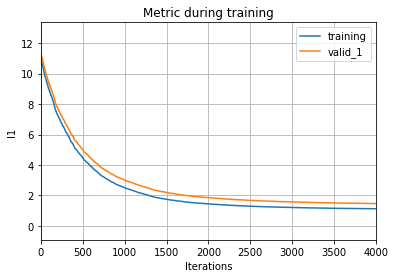

Our val mae score is 2.662376230653668


NameError: ignored

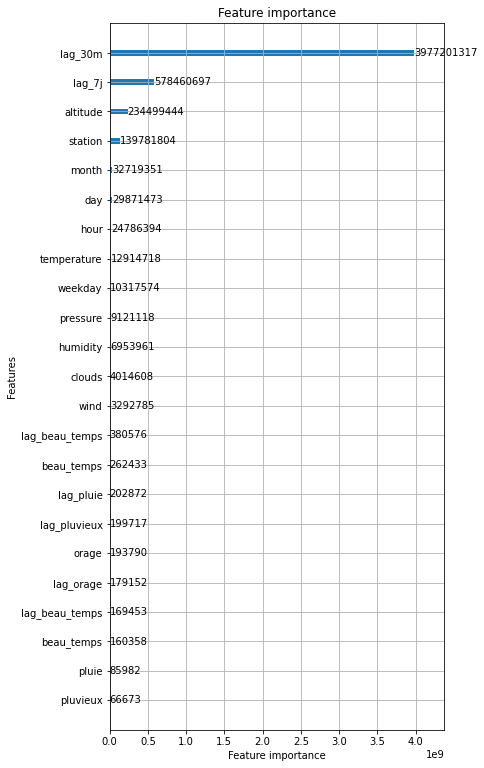

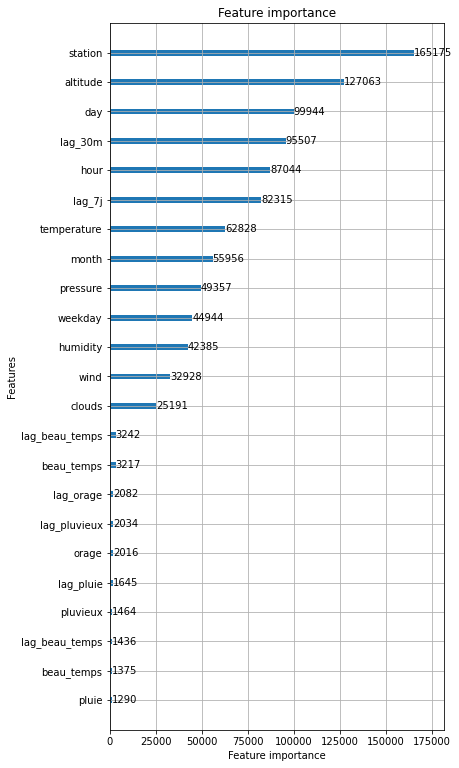

In [ ]:
%%time
import lightgbm as lgb


y_pred, model= run_lgb(x_train, y_train, x_val, y_val,test)

In [ ]:
y_pred


NameError: ignored